# Yelp Restaurants Rating Prediction from Reviews

## Introduction

Yelp is a business directory service and crowd-sourced review forum. Yelp reviews consist of comments and rating levels. However, sometimes the rating levels could be inconsistent with the comments. Maybe Reviewers are hired to give good rating levels, or reviewers are not giving reviews seriously. Our model will predict ratings based on review text.

This model can be applied on the following scenarios:

Detect inconsistency between ratings and review text, find invalid reviews.
If there ratings are missing, we can generate ratings from text so that this review could be used in the future.
This notebook will cover the following contents:

### Table of Contents

* [Data Scraper](#Data%20Scraper)
* [Model Training](#Model-Training)
* [Data Analysis](#Data-Analysis)
* [Conclusion](#Conclusion)

## Data Scraper

In this part, we use BeautifulSoup to parse the html information from the webpages, then we use Yelp Developers API to extract restaurant reviews. We extract around 80K reviews from restaurant located in 4 districts(Shadyside, Point Breeze, Downtown and Strip district) in Pittsburgh. We then combine the 4 sets of reviews together into a single csv file which will be used as a raw dataset for the model training in next part.

### 1. Install and import packages

We use BeautifulSoup to parse the html pages on Yelp website. The other packages are assumed to be installed on the machine.

In [1]:
# setup library imports
import io, time, json
import requests
from pathlib import Path
from bs4 import BeautifulSoup
import math

### 2. Get web page html

In [2]:
def retrieve_html(url):
    """
    Return the raw HTML at the specified URL.

    Args:
        url (string): 

    Returns:
        status_code (integer):
        raw_html (string): the raw HTML content of the response, properly encoded according to the HTTP headers.
    """
    response = requests.get(url)
    return response.status_code, response.text

### 3. Read yelp API key

In [3]:
def read_api_key(filepath="yelp_api_key.txt"):
    """
    Read the Yelp API Key from file.
    
    Args:
        filepath (string): File containing API Key
    Returns:
        api_key (string): The API Key
    """
    
    return Path(filepath).read_text().strip()

### 4. Get yelp business Info

In [ ]:
def yelp_search(api_key, query):
    """
    Make an authenticated request to the Yelp API.

    Args:
        query (string): Search term

    Returns:
        total (integer): total number of businesses on Yelp corresponding to the query
        businesses (list): list of dicts representing each business
    """
    url = "https://api.yelp.com/v3/businesses/search"
    headers = {"Authorization" : "Bearer %s" % (api_key)}
    params = {"location" : query}
    response = requests.get(url, params = params, headers = headers)
    result = json.loads(response.text)
    return result["total"], result["businesses"]

### 5. Get all restaurants business information

The important module in this part is collecting all the restaurants based on the filter we set. Since the API has a limit of accessing frequenccy, we should scrap the results with short intervals and page by page.

In [ ]:
def all_restaurants(api_key, query):
    """
    Retrieve ALL the restaurants on Yelp for a given query.

    Args:
        query (string): Search term

    Returns:
        results (list): list of dicts representing each business
    """
    url = "https://api.yelp.com/v3/businesses/search"
    headers = {"Authorization" : "Bearer %s" % (api_key)}
    offset = 0
    params = {"location" : query, "categories": "restaurants", "limit": 40}
    response = requests.get(url, params = params, headers = headers)
    result = json.loads(response.text)
    total = result["total"]
    final = []
    
    while offset<total:
        params["offset"] = offset
        response = requests.get(url, params = params, headers = headers)
        offset += 40
        result = json.loads(response.text)
        final += result["businesses"]
        time.sleep(0.2)
    return final

### 6. Get urls from business information

In [ ]:
def parse_api_response(data):
    """
    Parse Yelp API results to extract restaurant URLs.
    
    Args:
        data (string): String of properly formatted JSON.

    Returns:
        (list): list of URLs as strings from the input JSON.
    """
    
    return [ele["url"].split("?")[0] for ele in data]

### 7. Parse html page

In [ ]:
def parse_page(html):

    soup = BeautifulSoup(html, "html.parser")
    
    result = []
    reviews = soup.find_all("script",attrs={"type":"application/ld+json"})[0]
    reviews = json.loads(reviews.contents[0])
    reviews_count = reviews["aggregateRating"]["reviewCount"]
    reviews = reviews["review"]
    for review in reviews:
        tmp = {}
        tmp["author"] = review["author"]
        tmp["rating"] = float(review["reviewRating"]["ratingValue"])
        tmp["date"] = review["datePublished"]
        tmp["description"] = review["description"]
        result.append(tmp)
         
    return result, math.ceil(reviews_count/20)

### 8. Extract yelp review from html pages

In [ ]:
def extract_reviews(url):
    """
    Retrieve ALL of the reviews for a single restaurant on Yelp.

    Parameters:
        url (string): Yelp URL corresponding to the restaurant of interest.

    Returns:
        reviews (list): list of dictionaries containing extracted review information
    """
    tmp, pages = parse_page(retrieve_html(url)[1])
    res = []
    for i in range(pages):
        print(f"parsing - {i} page")
        if i>10:
            break
        if i>0:
            current, tmp_count = parse_page(retrieve_html(url+"?start="+str(20*i))[1])
        else:
            current = tmp
        res+=current[:]
    
    return res

### 9. Start scrap yelp review data

In [ ]:
api_key = read_api_key()
places = ['Shadyside, Pittsburgh','Downtown, Pittsburgh', 'Point Breeze, Pittsburgh']

for place in places:
    print(f"Search restaurants in {place} :")
    businesses = all_restaurants(api_key, place)
    urls = set(parse_api_response(businesses))
    
    print("Start extract reviews:")
    with open(place+".review","w") as fd:
        for url in urls:
            print(url)
            try:
                reviews = extract_reviews(url)
                reviews = [json.dumps(rev) for rev in reviews]
                print(f"reviews number: {len(reviews)}, distinct_reviews: {len(set(reviews))}")
                for review in reviews:
                    fd.write(review+"\n")
            except Exception:
                print("Running into error!")
                print(Exception)
                continue

### 10. Transform review data file from json to csv

In [ ]:
import csv
places = ['Shadyside, Pittsburgh','Downtown, Pittsburgh', 'Point Breeze, Pittsburgh']
file_names = [place+".review" for place in places]

entire_review_data = []

for file_name in file_names:
    with open(file_name, "r") as fd:
        line = fd.readline()
        while line :
            review_dict = json.loads(line)
            text, rating = review_dict["description"], review_dict["rating"]
            text = text.replace("\"","\'").replace("\n", "")
            entire_review_data.append([rating, text])
            line = fd.readline()

def write_csv_file(file_name, review_data):
    with open(file_name, "w") as fd:
        fd.write("rating,text\n")
        for rating, text in review_data:
            fd.write("\""+str(rating)+"\""+","+"\""+text+"\"\n")

### 11. Split dataset to train, dev and test

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(entire_review_data, test_size=0.3, random_state=15618)

write_csv_file("Pittsburgh_review.train", train_data)
write_csv_file("Pittsburgh_review.test", test_data)

### 12. References

In this part we develop our data scraper based on the yelp scraper in homework1.

## Model Training

In this notebook, we use Pytorch to build a simple bidirectional LSTM network and train it to predict the review ratings given the content. We first tokenize our input review data from the CSV files and feed the processed data into the neural network. Then we train our model for several epochs, and finally we get the output predictions from the learnt model on the test dataset. 

### 1. Install and import packages

We will use mainly Pytorch and Pandas in this task. The installations are quite simple so we just assume that they are installed already on your machine.

In [2]:
import torch
from torchtext import data
import pandas as pd
from pandas import DataFrame
import random
import matplotlib.pyplot as plt
import numpy as np

The torchtext contains useful dataset modules which help us define how to tokenize and organize the input data. We use spacy as the tokenizer and we convert the label data to long float type. The detailed usage of torchtext dataset can be found [here](https://torchtext.readthedocs.io/en/latest/data.html).

In [3]:
SEED = 15618

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize = "spacy")
LABEL = data.LabelField(dtype = torch.long)

### 2. Prepare datasets and iterator

The second step of is to define the datasets. Since we have already stored the review and rating records in the csv files, we simply use Pandas to read the data into memory and then convert the data to well-organized datasets. Once we create the datasets, we define the iterators which will yield data batches to our model during training and testing.

In [4]:
train_file = "Pittsburgh_review.train"
test_file = "Pittsburgh_review.test"

train_data, train_labels = pd.read_csv(train_file)["text"].tolist(), pd.read_csv(train_file)["rating"].tolist()
print(train_data[:1], train_labels[:1])

test_data, test_labels = pd.read_csv(test_file)["text"].tolist(), pd.read_csv(test_file)["rating"].tolist()
print(test_data[:1], test_labels[:1])



["Food was delicious. I highly recommend it. Iskender and the kebabs were tasty. For an appetizer I recommend sigara borek, and for dessert we had kazandibi. As a native of Turkey, I can verify this food is authentic- perhaps even as good as my mother's. The service was impeccable- they were flexible with our orders and allowed us to combine parts of two entrees into one.This is a must-go restaurant if you are in Oakland."] [5.0]
["I've eaten at this restaurant a lot over the years, and I love it. In the past year or two I mostly phone in an order from the Southside where I work, drive to Oakland to pick it up, then drive home to Mt. Washington. I think the fact that I go out of my way to get take-out says a lot about how much I like it.My favorite dishes are the Rangoon Night Market Noodles, Pad Thai, and the appetizer of mussels in a really tasty lemongrass broth. I rarely get anything else, but when I go with friends they do, and they usually seem to like what they get as well."] [5

We use torchtext's tabular dataset to store the processed data. We create 2 datasets for training and testing separately. Each dataset has 2 columns denoting the review content and the rating score.

In [5]:
TRAIN_CSV = "train_data.csv"
TEST_CSV = "test_data.csv"

TRAIN_DATA = {"text":train_data,"label":train_labels}
TEST_DATA = {"text":test_data,"label":test_labels}

df_train = DataFrame(TRAIN_DATA,columns = ["text","label"])
df_train.to_csv(TRAIN_CSV)

df_test = DataFrame(TEST_DATA,columns = ["text", "label"])
df_test.to_csv(TEST_CSV)

train_dataset = data.TabularDataset(path = TRAIN_CSV,format = "csv",fields = [("id",None),("text",TEXT),("label",LABEL)],skip_header = True)
test_dataset = data.TabularDataset(path = TEST_CSV,format = "csv",fields = [("id",None),("text",TEXT),("label",LABEL)],skip_header = True)

print("Train\t","Len:\t",len(train_dataset),vars(train_dataset.examples[0]))
print("Test\t" ,"Len:\t",len(test_dataset) ,vars(test_dataset.examples[0]))


Train	 Len:	 65753 {'text': ['Food', 'was', 'delicious', '.', 'I', 'highly', 'recommend', 'it', '.', 'Iskender', 'and', 'the', 'kebabs', 'were', 'tasty', '.', 'For', 'an', 'appetizer', 'I', 'recommend', 'sigara', 'borek', ',', 'and', 'for', 'dessert', 'we', 'had', 'kazandibi', '.', 'As', 'a', 'native', 'of', 'Turkey', ',', 'I', 'can', 'verify', 'this', 'food', 'is', 'authentic-', 'perhaps', 'even', 'as', 'good', 'as', 'my', 'mother', "'s", '.', 'The', 'service', 'was', 'impeccable-', 'they', 'were', 'flexible', 'with', 'our', 'orders', 'and', 'allowed', 'us', 'to', 'combine', 'parts', 'of', 'two', 'entrees', 'into', 'one', '.', 'This', 'is', 'a', 'must', '-', 'go', 'restaurant', 'if', 'you', 'are', 'in', 'Oakland', '.'], 'label': '5.0'}
Test	 Len:	 28181 {'text': ['I', "'ve", 'eaten', 'at', 'this', 'restaurant', 'a', 'lot', 'over', 'the', 'years', ',', 'and', 'I', 'love', 'it', '.', 'In', 'the', 'past', 'year', 'or', 'two', 'I', 'mostly', 'phone', 'in', 'an', 'order', 'from', 'the', 'S

The datasets we have now are still raw texts, which could not be recognized and utilized by our model. The tokenizer we defined above will do this for us. We use Glove as our tokenizer vector and build the vocabulary.

In [6]:
MAX_VOCAB_SIZE = 5000

TEXT.build_vocab(train_dataset,max_size=MAX_VOCAB_SIZE,vectors="glove.6B.200d", unk_init=torch.Tensor.normal_)
LABEL.build_vocab(train_dataset)

print("TEXT:",len(TEXT.vocab),"LABEL:",len(LABEL.vocab))
print(TEXT.vocab.freqs.most_common(20))
print(TEXT.vocab.itos[:10])
print(LABEL.vocab.stoi)

TEXT: 5002 LABEL: 5
[('.', 461347), ('the', 314004), (',', 275848), ('and', 255500), ('I', 214470), ('a', 192399), ('to', 154368), ('was', 147317), ('of', 114586), ('is', 97687), ('it', 94400), (' ', 93496), ('for', 84739), ('The', 78618), ('in', 77689), ('!', 71255), ('with', 66798), ('that', 62219), ('but', 59109), ('you', 50463)]
['<unk>', '<pad>', '.', 'the', ',', 'and', 'I', 'a', 'to', 'was']
defaultdict(None, {'5.0': 0, '4.0': 1, '3.0': 2, '1.0': 3, '2.0': 4})


Now we can finally define the data iterator with all the subparts we define above. Notice that we define the batch size quite small since our machine cannot take into larger batches into memory. You can change this variable according to your machine type. 

In [7]:
BATCH_SIZE = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator = data.BucketIterator.splits(
        (train_dataset, test_dataset),
        sort_within_batch=True, 
        sort_key=lambda x: len(x.text),
        batch_size=BATCH_SIZE,
        device=device)

### 3. Model Design

Many deep learning NLP and machine translation models are involved with recurrent neural network(RNN) structures. It's mainly because languages are constituency, the words are dependent with each other and rich of context information, which reflects sentiment. And RNN was born with the structure that can memory the sequential information and perform well on relevent tasks.

The ratings of the reviews can somewhat indicate the attitude or emotion of the review contents. So we team think that an RNN-based model can do well on this classification task. Also the LSTM network is an improved version from original RNN which can deal with the long history memory problem. We implement a one-layer bidirectional LSTM network. 

In [8]:
import torch.nn as nn

DROP = 0.1
class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):       
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim)  
        self.rnn = nn.LSTM(embedding_dim,hidden_dim,2,dropout = DROP,bidirectional = True)
        self.fc = nn.Linear(hidden_dim*2, output_dim)
        self.dropout = torch.nn.Dropout(DROP)
        
    def forward(self, text):
      
        embedded = self.embedding(text)
        output, hidden = self.rnn(embedded)
#         res = self.dropout(torch.sum(hidden[0],0))
#         print(output.size())
        res = self.dropout(torch.mean(output,0))
        return self.fc(res)

The parameters are defined below. The input dimension of the layers are equal to our vocabulary size(total number of tokens). Other parameters can be defined manually.

In [9]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 256
HIDDEN_DIM = 256
OUTPUT_DIM = 5

model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)

In [10]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')


The model has 3,912,709 trainable parameters


The model should update its parameters according to an objective function. The loss function should be defined and the model can perform the back propagation based on that value.

In [11]:
import torch.optim as optim
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# optimizer = optim.SGD(model.parameters(), lr=1e-2)

In [12]:
criterion = torch.nn.CrossEntropyLoss()

We train our model on an NVIDIA P100 GPU but the device can be a CPU as well.

In [13]:
model = model.to(device)
criterion = criterion.to(device)

In [14]:
def calculate_accuracy(preds, y):
    """
    Returns accuracy per batch
    """
    values, indices = torch.max(preds, 1)
    res = indices.cpu().detach().numpy()
    correct = (y.cpu().detach().numpy()==res)
    acc = sum(correct) / len(correct)
    return acc, np.copy(res), np.copy(y.cpu().detach().numpy())


The training function. We store the accuracy and loss value for every epoch.

In [15]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator: 
        optimizer.zero_grad()
        predictions = model(batch.text).squeeze(1)
        loss = criterion(predictions, batch.label)
        acc, _, _ = calculate_accuracy(predictions, batch.label)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [16]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        for batch in iterator:
            predictions = model(batch.text).squeeze(1)
            loss = criterion(predictions, batch.label)
            acc, pred_res, label_res = calculate_accuracy(predictions, batch.label)
            with open("predict.out", "w") as fd:
                fd.write("Predictions, Labels\n")
                for curr_pred, curr_label in zip(pred_res, label_res):
                    fd.write(f"{curr_pred},{curr_label}\n")
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


In [17]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

We train this model with 20 epochs.

In [18]:
N_EPOCHS = 20

best_valid_loss = float('inf')
train_losses, valid_losses = [], []
train_accs, valid_accs = [], []

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accs.append(train_acc)
    valid_accs.append(valid_acc)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')


Epoch: 01 | Epoch Time: 1m 9s
	Train Loss: 1.091 | Train Acc: 52.69%
	 Val. Loss: 0.961 |  Val. Acc: 57.88%
Epoch: 02 | Epoch Time: 1m 8s
	Train Loss: 0.889 | Train Acc: 61.04%
	 Val. Loss: 0.895 |  Val. Acc: 60.22%
Epoch: 03 | Epoch Time: 1m 8s
	Train Loss: 0.822 | Train Acc: 64.00%
	 Val. Loss: 0.842 |  Val. Acc: 63.17%
Epoch: 04 | Epoch Time: 1m 8s
	Train Loss: 0.773 | Train Acc: 66.52%
	 Val. Loss: 0.805 |  Val. Acc: 64.35%
Epoch: 05 | Epoch Time: 1m 8s
	Train Loss: 0.726 | Train Acc: 68.34%
	 Val. Loss: 0.786 |  Val. Acc: 66.03%
Epoch: 06 | Epoch Time: 1m 9s
	Train Loss: 0.691 | Train Acc: 70.10%
	 Val. Loss: 0.785 |  Val. Acc: 66.34%
Epoch: 07 | Epoch Time: 1m 9s
	Train Loss: 0.652 | Train Acc: 72.02%
	 Val. Loss: 0.835 |  Val. Acc: 64.22%
Epoch: 08 | Epoch Time: 1m 8s
	Train Loss: 0.615 | Train Acc: 74.04%
	 Val. Loss: 0.784 |  Val. Acc: 67.21%
Epoch: 09 | Epoch Time: 1m 8s
	Train Loss: 0.575 | Train Acc: 75.91%
	 Val. Loss: 0.810 |  Val. Acc: 67.16%
Epoch: 10 | Epoch Time: 1m 8

We can plot the accuracy and loss through epochs.

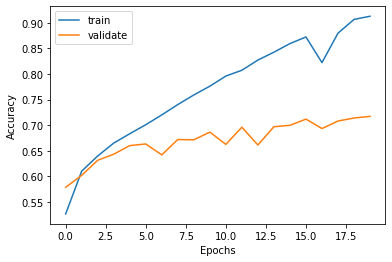

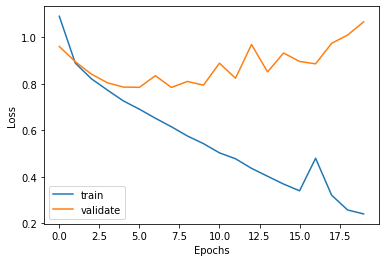

In [19]:
x = np.arange(20)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(x, train_accs, label="train")
plt.plot(x, valid_accs, label="validate")
plt.legend()
plt.show()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(x, train_losses, label="train")
plt.plot(x, valid_losses, label="validate")
plt.legend()
plt.show()

From the above diagrams, we can tell that the accuracy can be about 90% for training dataset, 70% for validation dataset.

### 4.References

Natural Language Process final homework (haotian2 was TA for 11611 NLP course and modify the LSTM model from sentiment analysis work to current 5 classes rating prediction task. 


## Data Analysis

In this part we will do data analysis for the actual reviews and our prediction. We plot the distribution of different rating classes to find the difference between true labels and prediction. And we use wordcloud to show most frequent words in different rating classes. Finally, we will use our model for anomaly detection, find inconsistent rating and text reviews.

### Rating Class Counts

In this part we will try to plot the distribution of each rating classes in the real reviews and in our predicted reviews.

In [7]:
import pandas as pd
import numpy as np

In [8]:
# Plot bar chart with number of reviews in different rating classes
# data: list[list[text], list[rating_class]]
def rating_count_plot_bar(df):
    ratings = list(df["label"])
    rating_classes, counts = np.unique(ratings, return_counts=True)
    df = pd.DataFrame({'Ratings': rating_classes, 'Counts':counts})
    ax = df.plot.bar(x='Ratings', y='Counts', rot=0)

In [9]:
def rating_count_plot_pie(df):
    ratings = list(df["label"])
    rating_classes, counts = np.unique(ratings, return_counts=True)
    dff = pd.DataFrame({'Ratings': list(counts)}, index=list(rating_classes))
    plot = dff.plot.pie(y='Ratings')

First I will plot the result of actual test dataset.

In [ ]:
df = pd.read_csv("./test_data.csv")

In [ ]:
rating_count_plot_bar(df)

In [ ]:
rating_count_plot_pie(df)

Then we will plot counts in each rating class with our predction:

In [ ]:
pred_df = pd.read_csv("./test_data.csv")

In [ ]:
rating_count_plot_bar(pred_df)

In [ ]:
rating_count_plot_pie(pred_df)

### Top Words in Different Classes

In this part we will plot most frequent words in different rating classes.

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt 

In [ ]:
words_1 = ""
words_2 = ""
words_3 = ""
words_4 = ""
words_5 = ""
for index, row in df.iterrows():
    if row['label'] == 1.0:
        words_1 += row['text']
    elif row['label'] == 2.0:
        words_2 += row['text']
    elif row['label'] == 3.0:
        words_3 += row['text']
    elif row['label'] == 4.0:
        words_4 += row['text']
    elif row['label'] == 5.0:
        words_5 += row['text']

In [ ]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = STOPWORDS, 
                min_font_size = 10).generate(words_1) 
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 